In [146]:
import matplotlib.pyplot as plt
from skyfield.api import EarthSatellite, load, wgs84
from datetime import datetime, timedelta
import numpy as np
import types
from scipy import signal, constants

In [2]:
ts = load.timescale()

In [15]:
earth_radius_km = 6378.137

In [74]:
satelites = [
    types.SimpleNamespace(name='PolarCube', tle_filename='PolarCube.txt', tles=pcube_tles, info=pcube_info),
    types.SimpleNamespace(name='RAD-FX-2', tle_filename='RadFxSat-2.txt', tles=radfx2_tles, info=radfx2_info),
    #types.SimpleNamespace(name='CACTUS-1', tle_filename='CACTUS-1.txt'),
    types.SimpleNamespace(name='ExoCube-2', tle_filename='ExoCube-2.txt', tles=None, info=None),
    types.SimpleNamespace(name='MiTEE-1', tle_filename='MiTEE-1.txt', tles=None, info=None),
    #types.SimpleNamespace(name='Q-PACE', tle_filename='Q-PACE.txt'),
    #types.SimpleNamespace(name='TechEdSat-7', tle_filename='TechEdSat-7.txt'),
    types.SimpleNamespace(name='CAPE-3', tle_filename='CAPE-3.txt', tles=None, info=None),
    #types.SimpleNamespace(name='PICS-1', tle_filename='PICS-1.txt'),
    #types.SimpleNamespace(name='PICS-2', tle_filename='PICS-2.txt'),
    types.SimpleNamespace(name='Prometheus-2-8', tle_filename='Prometheus-2-8.txt', tles=None, info=None),
    types.SimpleNamespace(name='Prometheus-2-11', tle_filename='Prometheus-2-11.txt', tles=None, info=None),

    types.SimpleNamespace(name='GEMS-1', tle_filename='gems-1-tle.txt', tles=gems1_tles, info=gems1_info)
]

In [75]:
def get_tles(filename):
    with open('tles/'+ filename, 'r') as f:
        lines = [x.strip() for x in f.readlines()]
    return list(zip(lines[::2], lines[1::2]))

In [76]:
def get_orbital_info(tles):
    epochs = []
    apogees = []
    perigees = []

    for tle in tles:

        pcube = EarthSatellite(tle[0], tle[1], 'POLARCUBE', load.timescale())

        elevations = []
        for i in range(90):
            t = ts.utc(pcube.epoch.utc_datetime() + timedelta(seconds=60*i))
            elevations.append(np.max(pcube.at(t).distance().km))

        apogees.append(np.max(elevations))
        perigees.append(np.min(elevations))    
        epochs.append(pcube.epoch.tt)

    return types.SimpleNamespace(epochs=epochs, apogees=np.array(apogees), perigees=np.array(perigees))

In [77]:
for satelite in satelites:
    if satelite.tles is None:
        satelite.tles = get_tles(satelite.tle_filename)
    if satelite.info is None:
        satelite.info = get_orbital_info(satelite.tles)

In [92]:
def plot_orbit_height(name, info):

    days_since_launch = info.epochs - info.epochs[0]
    
    plt.figure(figsize=(16,8))
    plt.title(name + ' Apogees/Perigees')
    plt.xlabel('Days Since Launch')
    plt.ylabel('Orbital Height (km)')
    plt.plot(days_since_launch, info.apogees - earth_radius_km, label='Apogees')
    plt.plot(days_since_launch, info.perigees - earth_radius_km, label='Perigees')
    plt.plot(days_since_launch, ( (info.perigees + info.apogees) / 2) - earth_radius_km, label='Mean')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()

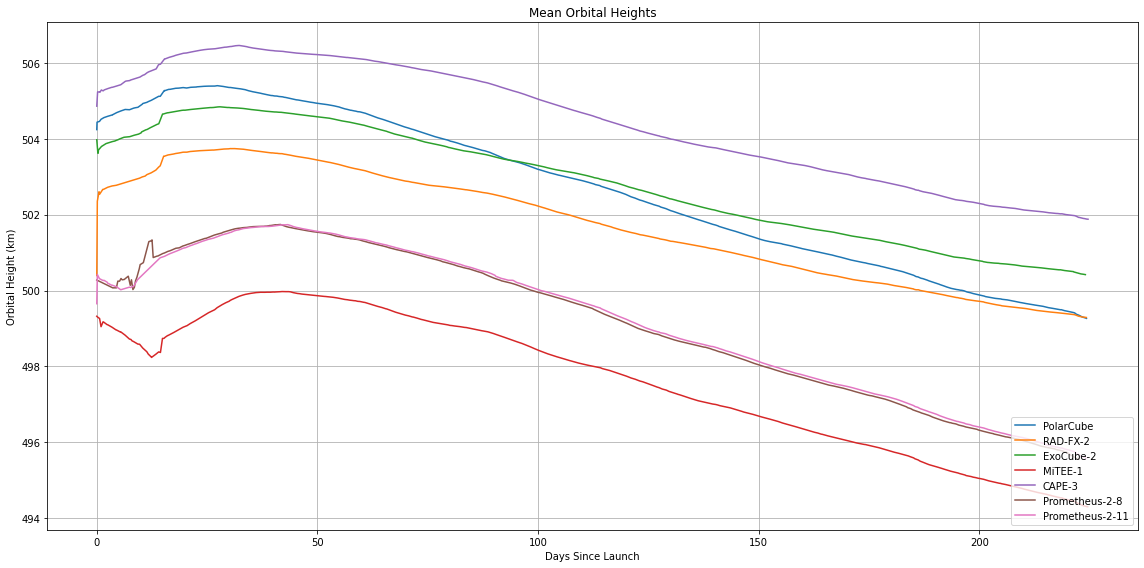

In [91]:
plt.figure(figsize=(16,8))

for satelite in satelites:

    if(satelite.name == 'GEMS-1'):
        continue
    
    name = satelite.name
    info = satelite.info
    
    days_since_launch = info.epochs - info.epochs[0]
    
    plt.title('Mean Orbital Heights')
    plt.xlabel('Days Since Launch')
    plt.ylabel('Orbital Height (km)')
    plt.plot(days_since_launch, ( (info.perigees + info.apogees) / 2) - earth_radius_km, label=name)

plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

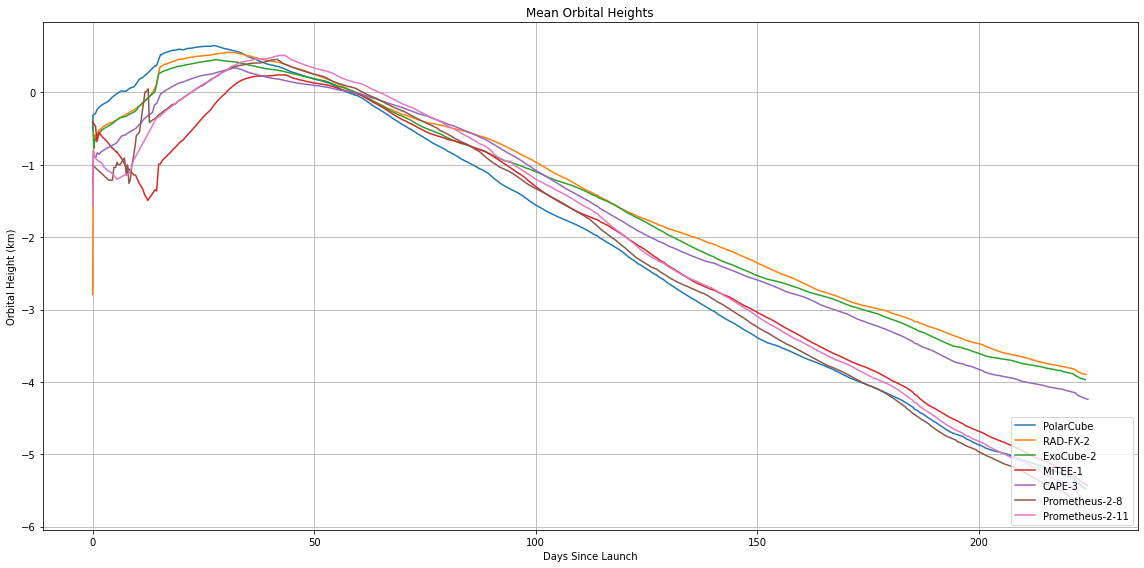

In [135]:
plt.figure(figsize=(16,8))

for satelite in satelites:

    if(satelite.name == 'GEMS-1'):
        continue
    
    name = satelite.name
    info = satelite.info
    
    days_since_launch = info.epochs - info.epochs[0]
    
    mean_height = ( (info.perigees + info.apogees) / 2) - earth_radius_km

    mean_height = mean_height - mean_height[150]
    
    plt.title('Mean Orbital Heights')
    plt.xlabel('Days Since Launch')
    plt.ylabel('Orbital Height (km)')
    plt.plot(days_since_launch, mean_height, label=name)

plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

In [87]:
def triangle_filter(data, hw):

    # Build a unitary weight triangle filter
    filter_coeff = signal.windows.triang(1 + 2 * hw)
    filter_coeff /= np.sum(filter_coeff)

    # Extend the size of the data so the filter can work with the endpoints
    temp = np.concatenate((np.ones(hw) * data[0], data, np.ones(hw) * data[-1]))
    # Filter data
    temp = signal.convolve(temp, filter_coeff, mode='same')
    # Return the section that corresponds to the original data
    return temp[hw:-hw]

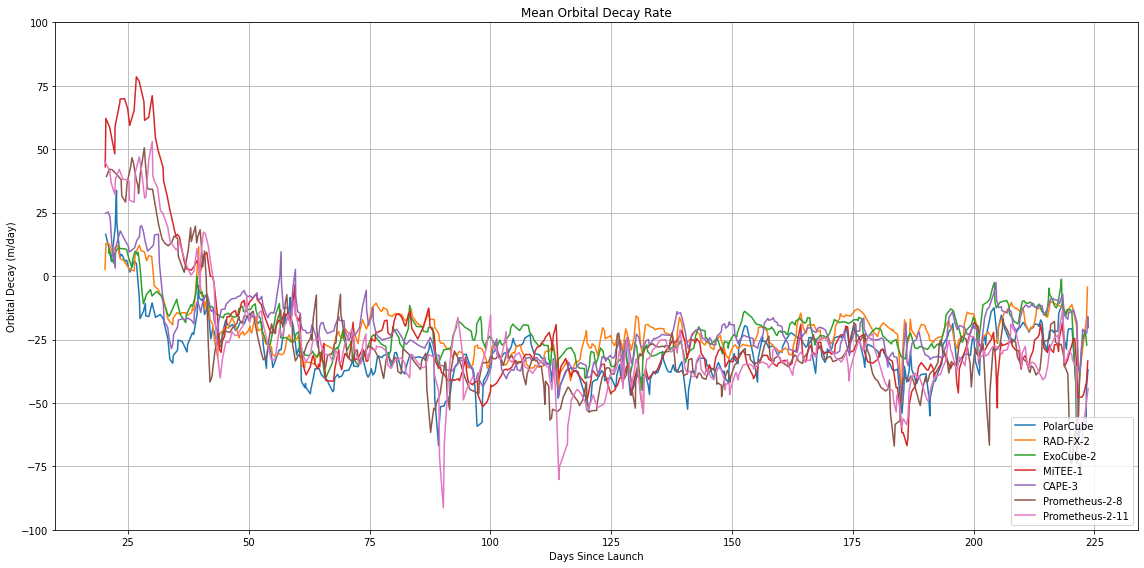

In [133]:
plt.figure(figsize=(16,8))

for satelite in satelites:

    if(satelite.name == 'GEMS-1'):
        continue
    
    days_since_launch = satelite.info.epochs - satelite.info.epochs[0]

    bad = np.where(np.logical_and(np.diff(days_since_launch) != 0, days_since_launch[:-1] > 20))

    days_since_launch = days_since_launch[bad]

    name = satelite.name
    info = satelite.info

    mean_elevation = (info.perigees[bad] + info.apogees[bad]) / 2

    decay_rate = np.diff(mean_elevation - earth_radius_km) / np.diff(days_since_launch) * 1000

    decay_rate = triangle_filter(decay_rate, 1)

    plt.title('Mean Orbital Decay Rate')
    plt.xlabel('Days Since Launch')
    plt.ylabel('Orbital Decay (m/day)')
    plt.plot(days_since_launch[:-1], decay_rate, label=name)

plt.ylim(-100, 100)
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

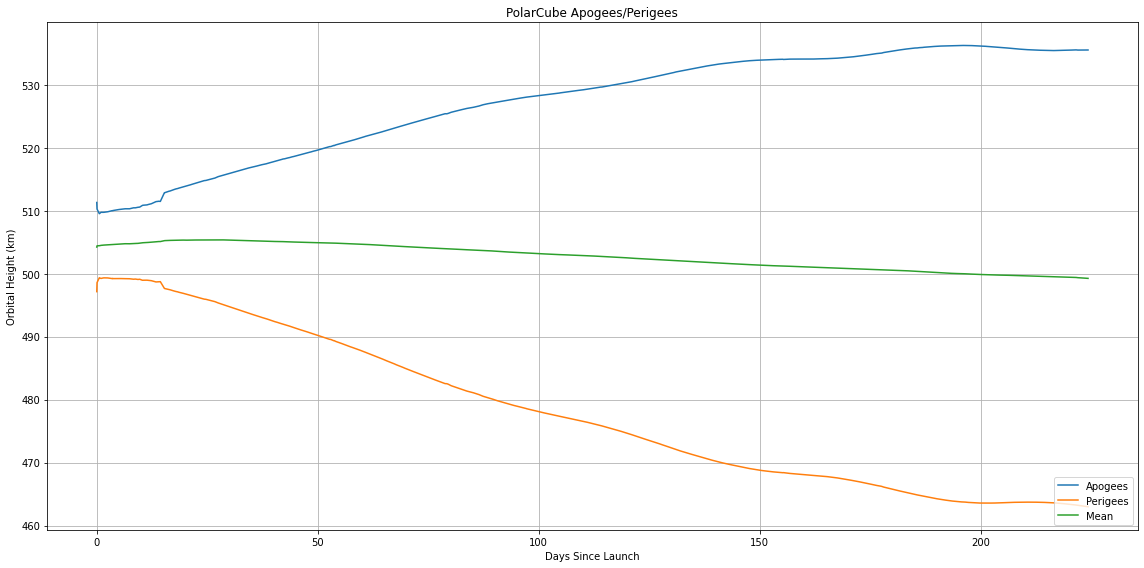

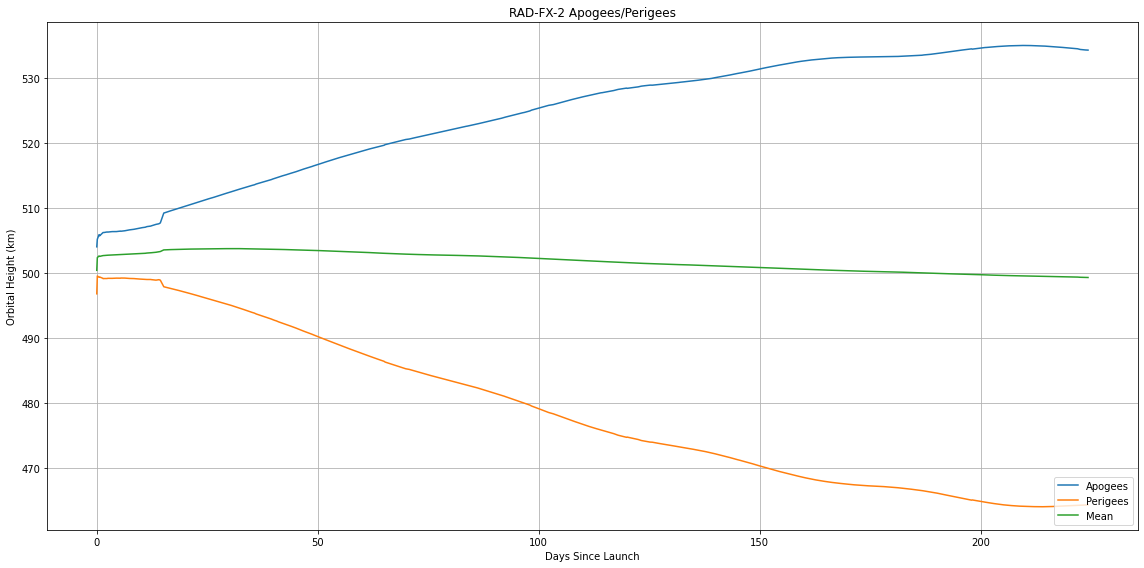

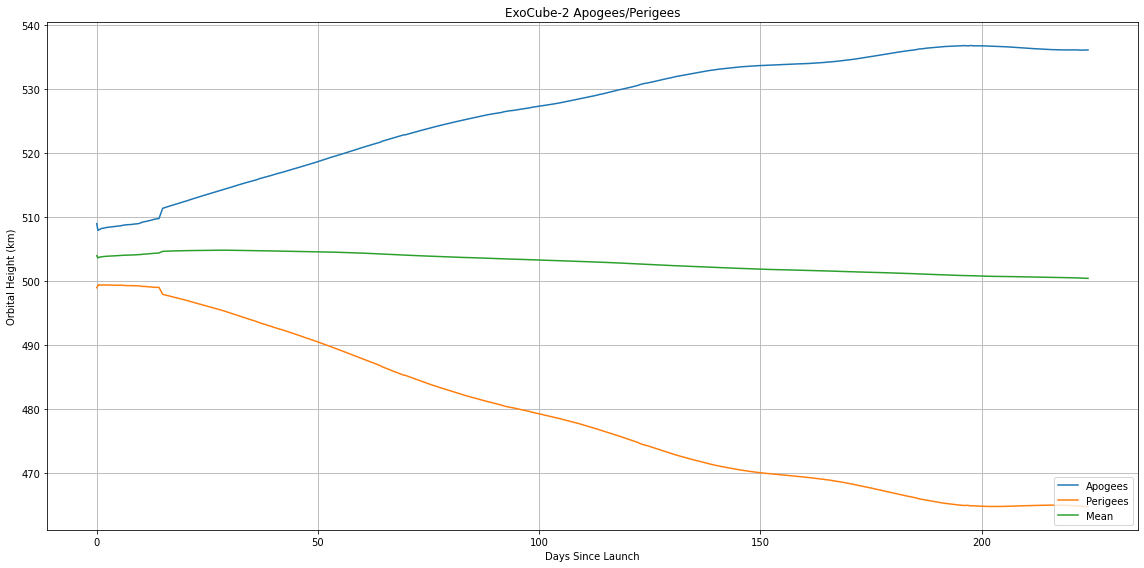

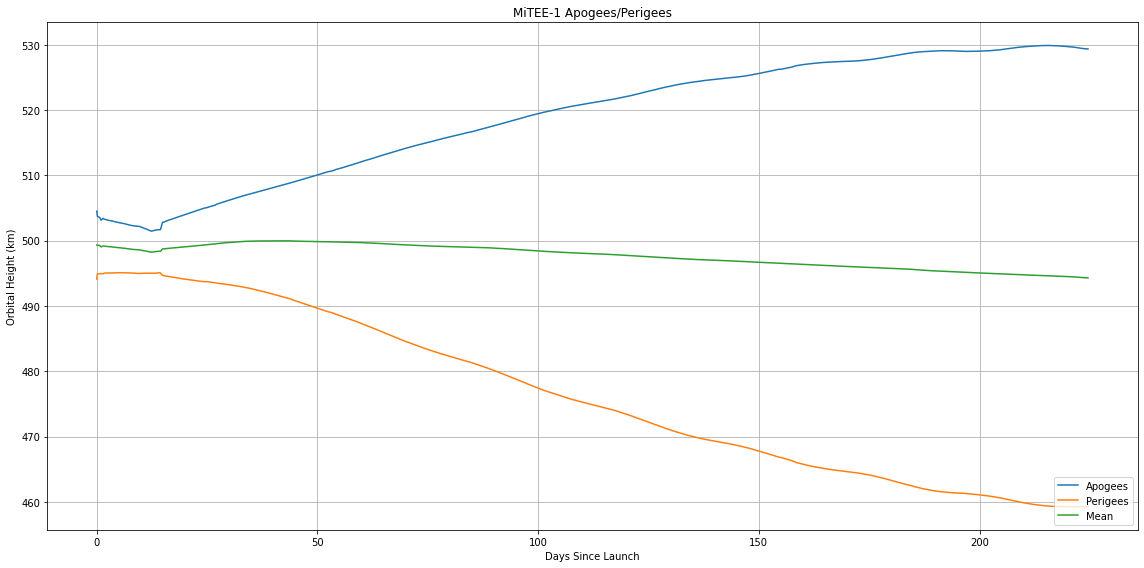

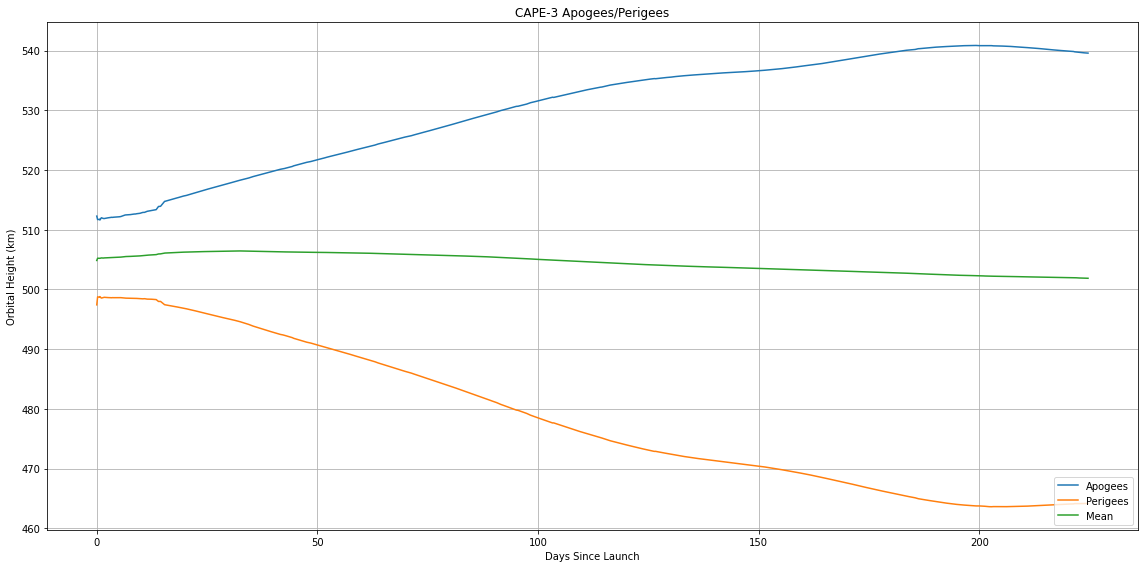

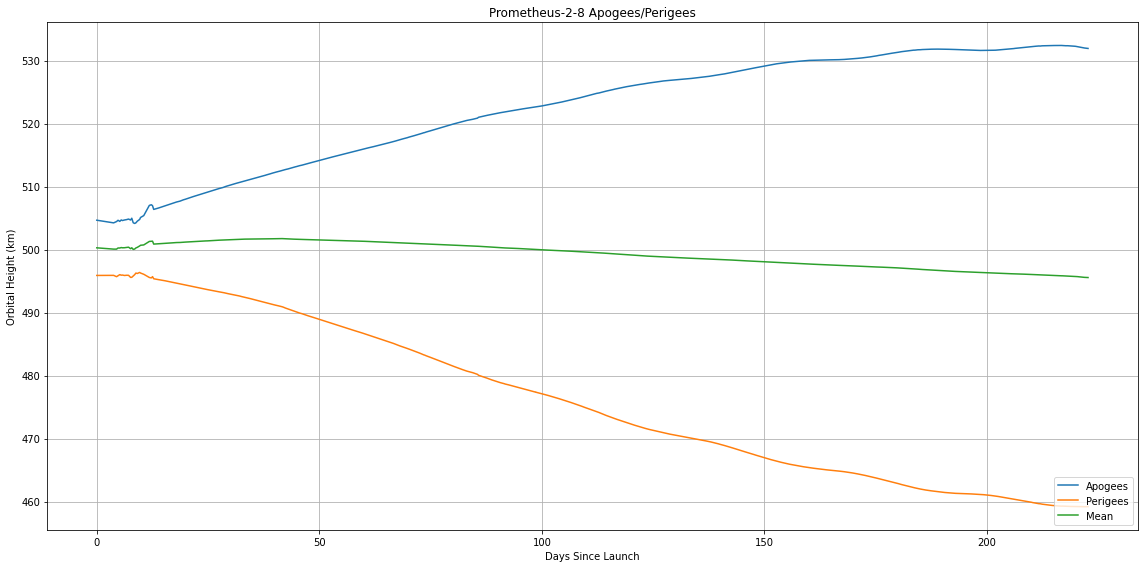

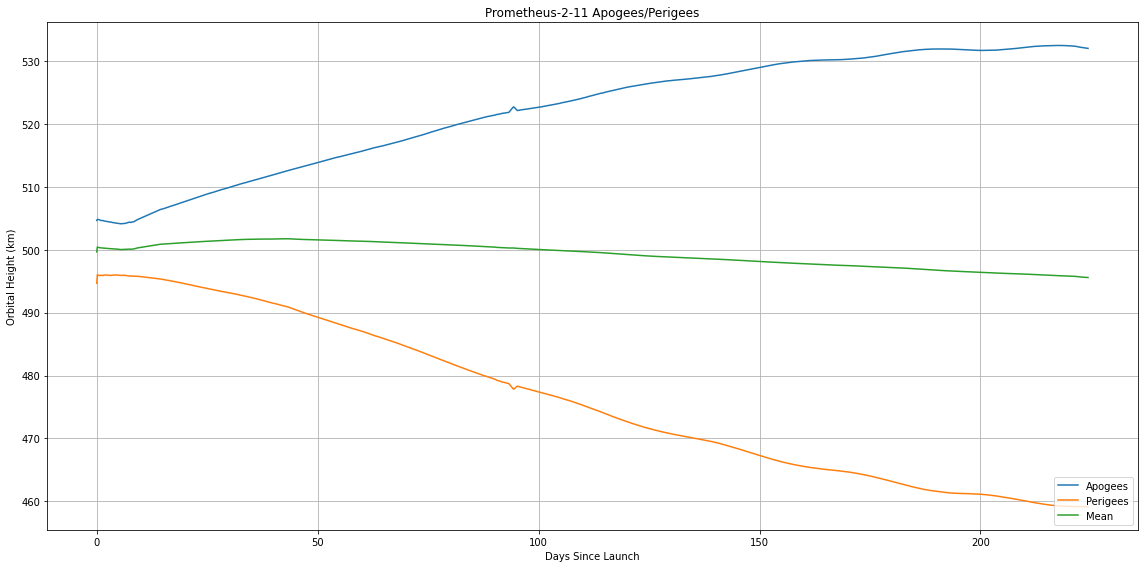

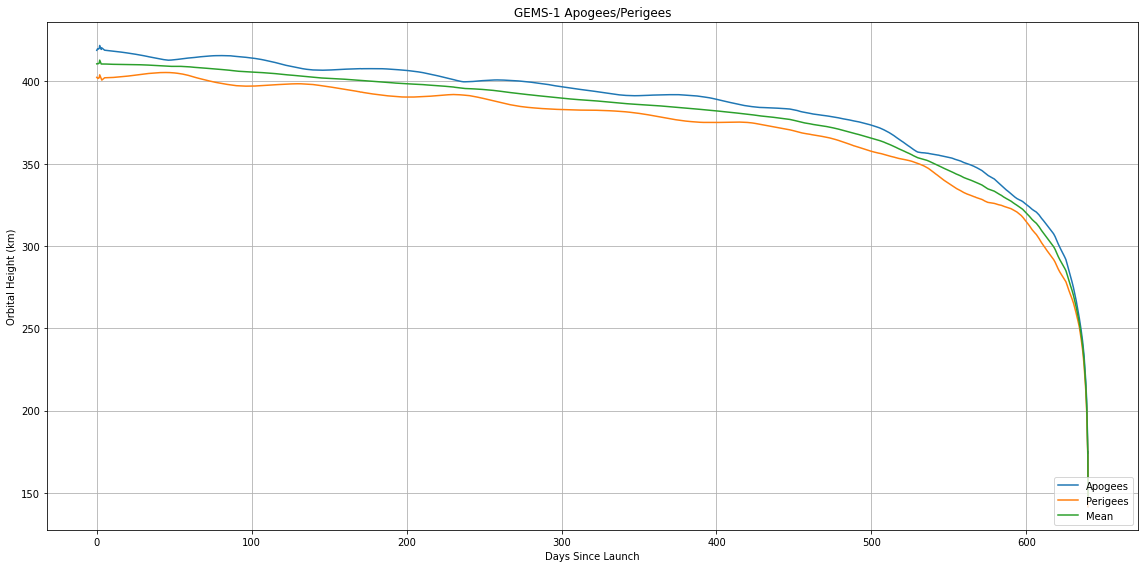

In [121]:
for satelite in satelites:
    plot_orbit_height(satelite.name, satelite.info)

In [269]:
D = 4.3
R = 4.3

In [270]:
f = (1/4) * (R + np.sqrt(R**2-(D/2)**2))

In [271]:
f

2.0059773090682715

In [272]:
f/D

0.4665063509461097

In [201]:
wavelength = constants.c / 8000e6

In [202]:
D / wavelength

114.74604874816431

In [203]:
10*np.log10((np.pi*D/wavelength)**2)

51.13775224675472

In [204]:
2 * R * np.sin( np.arccos( 1 - wavelength / (20 * R) ) ) 

0.2538529799319377

In [205]:
np.pi*(D/2)**2

14.522012041218817

In [206]:
0.5*0.5

0.25

In [207]:
14.5/0.25

58.0